In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Daset

El dataset que se utilizará fue extraído de: 
http://datos.jus.gob.ar/dataset/sneep

La documentación correspondiente se encuentra en: https://github.com/datos-justicia-argentina/Sistema-Nacional-de-Estadisticas-sobre-Ejecucion-de-la-Pena-SNEEP/blob/master/Sistema-Nacional-de-Estadisticas-sobre-Ejecucion-de-la-Pena-SNEEP-metadata.md

Los objetivos son:  &nbsp;

-Explorar el dataset y realizar un análisis preliminar de los datos. &nbsp;

-Reconocer personas privadas de la libertad con calificación de conducta baja para ser posibles beneficiarios de un programa interdisciplinario de seguimiento y contención.  &nbsp;
-Utilizar la importancia de las variables para utilizar como insumo para elaborar estrategias de acción. &nbsp;



In [2]:
data_sp = pd.read_csv("sneep-2019.csv", low_memory= False)

In [3]:
data_sp.head(3)

,censo_anio,provincia_id,provincia_descripcion,establecimiento_id,establecimiento_descripcion,edad,sexo_id,sexo_descripcion,nacionalidad_id,nacionalidad_descripcion,...,participa_programa_pre_libertad,participa_programa_prision_discontinua_id,participa_programa_prision_discontinua_descripcion,participa_programa_semi_detencion_id,participa_programa_semi_detencion_descripcion,tuvo_reduccion_pena_id,tuvo_reduccion_pena_descripcion,mujer_tiene_hijos_intramuro,provincia_indec_id,ultima_provincia_residencia_indec_id
0,2019,1,Buenos Aires,64,SPF - COMPLEJO PENITENCIARIO FEDERAL II -MAR...,54,1,Masculino,1,Argentina,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,6,2.0
1,2019,1,Buenos Aires,64,SPF - COMPLEJO PENITENCIARIO FEDERAL II -MAR...,44,1,Masculino,7,Peruana,...,2.0,1.0,No está incorporado,1.0,No tiene semidetención,4.0,No tuvo reducción de pena,0,6,6.0
2,2019,1,Buenos Aires,64,SPF - COMPLEJO PENITENCIARIO FEDERAL II -MAR...,41,1,Masculino,1,Argentina,...,2.0,1.0,No está incorporado,1.0,No tiene semidetención,4.0,No tuvo reducción de pena,0,6,6.0


In [4]:
data_sp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100634 entries, 0 to 100633
Data columns (total 86 columns):
 #   Column                                              Non-Null Count   Dtype  
---  ------                                              --------------   -----  
 0   censo_anio                                          100634 non-null  int64  
 1   provincia_id                                        100634 non-null  int64  
 2   provincia_descripcion                               100634 non-null  object 
 3   establecimiento_id                                  100634 non-null  int64  
 4   establecimiento_descripcion                         100634 non-null  object 
 5   edad                                                100634 non-null  int64  
 6   sexo_id                                             100634 non-null  int64  
 7   sexo_descripcion                                    100634 non-null  object 
 8   nacionalidad_id                                     100634 non-n

## Limpieza de datos

Se crea la columna **dias_detencion** a partir de la columna **fecha_detencion** restando la fecha de realización del censo que fue el 31/12/2019. Luego se eliminan los registros nulos.

In [5]:
fecha_censo=pd.Timestamp(2019,12,31)
fecha = data_sp["fecha_detencion"].apply(lambda x: np.NaN if x is np.NaN else pd.Timestamp(x))
data_sp["dias_detencion"] = fecha_censo-fecha

In [6]:
data_dias = data_sp.dropna(subset=["dias_detencion"])
data_dias["dias_detencion"].isnull().sum()

0

Para poder realizar el análisis, se decidió quitar los registros cuya detención es menor a 3 meses, es decir cuyos **dias_detencion** es menor a 90 días.

In [7]:
mask_fecha = data_dias["dias_detencion"]>"90 days"
data_90=data_dias[mask_fecha]

Se define utilizar únicamente los registros de establecimientos que cuenten con más de 100 personas privadas de su libertad. 

In [8]:
data_estab = data_90.groupby("establecimiento_descripcion")
data_establecimientos = data_estab.filter(lambda grupo: grupo["censo_anio"].count() > 100)

Respecto a los delitos en primer lugar se eliminan los registros nulos. &nbsp;

En segundo lugar se define cómo utilizar la información, en la documentación se indica que se registra en *delito1* el delito de mayor gravedad, y en el caso que haya cometido más de uno se registran como *delito2*, *delito3*, *delito4* y *delito5*. Se define utilizar **delito1_descripcion** para definir el delito y crear una columna **otros_delitos** que sea 1 un caso que se encuentre imputado por más de un delito y eliminar las columnas correspondientes a los*delito2*, *delito3*, *delito4* y *delito5*. &nbsp;

Por último, se define eliminar los registros de personas acusadas por los delitos "Delitos previstos en leyes especiales", "Del. contra la lib. comet. por func. público" y "Delitos contra los poderes publicos", debido a la naturaleza particular de los mismos.

In [9]:
data_delito = data_establecimientos.dropna(subset=["delito1_descripcion"])
mask_delitos=(data_delito["delito1_descripcion"]!="Delitos previstos en leyes especiales")&(data_delito["delito1_descripcion"]!="Del. contra la lib. comet. por func. público") & (data_delito["delito1_descripcion"]!="Delitos contra los poderes pugblicos")
data_2=data_delito[mask_delitos]

In [10]:
data_2["otros_delitos"]= data_2["delito2_descripcion"].apply(lambda x: 0 if x is np.NaN else 1)


C:\Users\Valeria\Anaconda3\envs\dhdsblend\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


#### Criterios metológicos

Se define utilizar solo alguna categorías dado que debido a sus particularidades, requíeren la confección de modelos específicos. &nbsp;

En primer lugar, se eliminaran todos los registros de personas cuya **situación_legal_descripcion** es "Inimputable" y "Otra situación". &nbsp;

En segundo lugar se eliminaran los registros de "Mujer" y "Transexual" para solo utilizar el caso de los "Masculino" que representan el 95% del dataset.&nbsp;

En tercer lugar se elimnan los registros cuya **calificación_conducta_descripción** es "Sin calificación".&nbsp;

En cuarto lugar se eliminan los registros que en edad se consigne menos de 18 años (hay registros con 0 o 1 que corresponden a datos nulos)

In [11]:
data_2["situacion_legal_descripcion"].value_counts()

Condenado         50434
Procesado         33344
Inimputable         190
Otra situación      104
Name: situacion_legal_descripcion, dtype: int64

In [12]:
mask_legal =(data_2["situacion_legal_descripcion"]!="Inimputable") &(data_2["situacion_legal_descripcion"]!="Otra situación")
data_3 = data_2[mask_legal]

In [13]:
mask_sexo =data_3["sexo_descripcion"]=="Masculino"
data_4 = data_3[mask_sexo]

In [14]:
mask_conducta =data_4["calificacion_conducta_descripcion"]!="Sin calificación"
data_5 = data_4[mask_conducta]

In [15]:
mask_edad = data_5["edad"]>17
data_6=data_5[mask_edad]

#### Imputación valores faltantes
Se define imputar los valores nulos considerando que la falta de registro implicaba la falta de participación en esas categorías, además son la moda en cada caso. Se realizaron las siguientes imputación en las siguientes features: &nbsp;

**participacion_programa_educativo_descripcion**: "No participa de ningún programa educativo" &nbsp;

**participo_alteracion_orden_ult_anio_descripcion**: "No participó de ninguna alteración"&nbsp;

**tipo_infraccion_disciplinaria_descripcion**: "No cometió Infracción disciplinaria"&nbsp;

**horas_trabajo_remunerado_descripcion**:"No tiene trabajo remunerado" &nbsp;

**sancion_aplicada_descripcion**:"No recibio sancion" &nbsp;

**tentativa_fugas_evasiones_descripcion**: "No" &nbsp;

**fue_lesionado_descripcion**: "No fue lesionado"&nbsp;

**intento_suicidio**: Se modificó la columna ya que según la documentación la codificación era: 0: sin datos, 1: Si, 2: No. Se modificó para que 0: No y 1: 0 &nbsp;

**fue_lesionado_descripcion**:"No fue lesionado" &nbsp;

**es_reincidente_descripcion**: Se modificó la columna siendo que en el caso que el registro sea "Reincidente (art. 50 CP)" o "Reiterante" tome el valor 0, sino 1.&nbsp;

**recibio_visitas_ultimo_anio**: Se modificó la columna de acuerdo a la documentación ya que  la codificación era: 0: sin datos, 1: Si, 2: No. Se modificó para que 0: No y 1: Si &nbsp;

**participacion_programa_laboral**: Se modificó la columna de acuerdo a la documentación ya que  la codificación era: 0: sin datos, 1: Si, 2: No. Se modificó para que 0: No y 1: Si &nbsp;

**participacion_actividades_deportivas**: Se modificó la columna de acuerdo a la documentación ya que  la codificación era: 0: sin datos, 1: Si, 2: No. Se modificó para que 0: No y 1: Si &nbsp;


In [16]:
data_6["participacion_programa_educativo_descripcion"]= data_6["participacion_programa_educativo_descripcion"].apply(lambda x: "No participa de ningún programa educativo" if x is np.NaN else x)
data_6["participo_alteracion_orden_ult_anio_descripcion"]= data_6["participo_alteracion_orden_ult_anio_descripcion"].apply(lambda x: "No participó de ninguna alteración" if x is np.NaN else x)
data_6["tipo_infraccion_disciplinaria_descripcion"]= data_6["tipo_infraccion_disciplinaria_descripcion"].apply(lambda x: "No cometió Infracción disciplinaria" if x is np.NaN else x)
data_6["horas_trabajo_remunerado_descripcion"]= data_6["horas_trabajo_remunerado_descripcion"].apply(lambda x: "No tiene trabajo remunerado" if x is np.NaN else x)
data_6["sancion_aplicada_descripcion"]= data_6["sancion_aplicada_descripcion"].apply(lambda x: "No recibio sancion" if x is np.NaN else x)
data_6["tentativa_fugas_evasiones_descripcion"]= data_6["tentativa_fugas_evasiones_descripcion"].apply(lambda x: "No" if x is np.NaN else x)
data_6["tentativa_suicidio"]= data_6["tentativa_suicidio"].apply(lambda x: 1 if x is 1 else 0)
data_6["fue_lesionado_descripcion"]= data_6["fue_lesionado_descripcion"].apply(lambda x: "No fue lesionado" if x is np.NaN else x)
data_6["es_reincidente_descripcion"]= data_6["es_reincidente_descripcion"].apply(lambda x: 1 if (x=="Reincidente (art. 50 CP)") | (x=="Reiterante") else 0)
data_6["recibio_visitas_ultimo_anio"]= data_6["recibio_visitas_ultimo_anio"].apply(lambda x: 1 if x == 1 else 0)
data_6["participacion_programa_laboral"]= data_6["participacion_programa_laboral"].apply(lambda x: 1 if x == 1 else 0)
data_6["participacion_actividades_deportivas"]= data_6["participacion_actividades_deportivas"].apply(lambda x: 1 if x == 1 else 0)


C:\Users\Valeria\Anaconda3\envs\dhdsblend\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Valeria\Anaconda3\envs\dhdsblend\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Valeria\Anaconda3\envs\dhdsblend\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

Dado que las siguientes situaciones solo son aplicadas a los casos de personas condenadas, los nulos corresponden a personas cuya situación legal es "Procesado" o "Otra situación" (Contraventor). Debido a esto la imputación de los nulos fue para dar cuenta de esta diferencia, además se definió esta categoría para los casos de falta de datos: &nbsp;

**tuvo_reduccion_pena_descripcion**: "No aplica" &nbsp;

**tiene_periodo_progresividad_descripcion**: "No aplica" &nbsp;

**tuvo_salidas_transitorias_descripcion**:"No aplica" &nbsp;

**participa_programa_semi_detencion_descripcion**: "No aplica" &nbsp;

**incorporado_reg_semi_libertad_descripcion**: "No aplica"&nbsp;

**participa_programa_prision_discontinua_descripcion**:"No aplica"&nbsp;

**participa_programa_pre_libertad**: Se modificó la columna  de acuerdo a la documentación ya que  la codificación era: 0: sin datos, 1: Si, 2: No. Se modificó para que 0: No y 1: Si &nbsp;

**tipo_condena**: Se modificó la columna de acuerdo a la documentación siendo que la codificación era: 0: sin datos, 1: Si fue condenado a cadena o reclusión perpetua, 2: No fue condenado a cadena o reclusión perpetua. Se modificó para que 0 corresponda a No y 1 a Si &nbsp;



In [128]:
data_6["tuvo_reduccion_pena_descripcion"] = data_6["tuvo_reduccion_pena_descripcion"].apply(lambda x: "No aplica" if x is np.NaN else x)
data_6["tiene_periodo_progresividad_descripcion"]= data_6["tiene_periodo_progresividad_descripcion"].apply(lambda x: "No aplica" if x is np.NaN else x)
data_6["tuvo_salidas_transitorias_descripcion"]= data_6["tuvo_salidas_transitorias_descripcion"].apply(lambda x: "No aplica" if x is np.NaN else x)
data_6["participa_programa_semi_detencion_descripcion"]= data_6["participa_programa_semi_detencion_descripcion"].apply(lambda x: "No aplica" if x is np.NaN else x)
data_6["incorporado_reg_semi_libertad_descripcion"]= data_6["incorporado_reg_semi_libertad_descripcion"].apply(lambda x: "No aplica" if x is np.NaN else x)
data_6["participa_programa_prision_discontinua_descripcion"]= data_6["participa_programa_prision_discontinua_descripcion"].apply(lambda x: "No aplica" if x is np.NaN else x)
data_6["participa_programa_pre_libertad"]= data_6["participa_programa_pre_libertad"].apply(lambda x: 1 if x == 1.0 else 0)
data_6["tipo_condena"] = data_6["tipo_condena"].apply(lambda x: 1 if x==1.0 else 0)


C:\Users\Valeria\Anaconda3\envs\dhdsblend\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Valeria\Anaconda3\envs\dhdsblend\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Valeria\Anaconda3\envs\dhdsblend\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

#### Eliminación de nulos

Se definen eliminar los registros nulos en las siguientes columnas: **nacionalidad_descripcion**, **estado_civil_descripcion**, **nivel_instruccion_descripcion**, **ultima_situacion_laboral_descripcion**, **capacitacion_laboral_al_ingresar_descripcion**, **ultimo_lugar_residencia_descripcion**, **ultima_provincia_residencia_descripcion**, **jurisdiccion_descripcion**, **establecimiento_procedencia_descripcion** y **calificacion_conducta_descripcion**.

In [18]:
data_sin_nulos = data_6.dropna(subset=["nacionalidad_descripcion", "estado_civil_descripcion", "nivel_instruccion_descripcion", "ultima_situacion_laboral_descripcion", "capacitacion_laboral_al_ingresar_descripcion", "ultimo_lugar_residencia_descripcion", "ultima_provincia_residencia_descripcion", "jurisdiccion_descripcion", "establecimiento_procedencia_descripcion", "calificacion_conducta_descripcion"])

Respecto al tiempo de condena, se definió utilizar la columna **duracion_condena_rango** siendo que se consideraron los registros nulos y los que faltaba información en la categoría "No condenado" y se recategorizó el código utilizando la información de la documentación. 

In [19]:
diccionario={0.0:"No condenado", np.NaN:"No condenado",
             1.0: "hasta 3 años",
             2.0: "3.1 a 6 años",
             3.0: "6.1 a 9 años",
             4.0: "9.1 a 12 años",
             5.0: "12.1 a 15 años",
             6.0: "15.1 a 18 años",
             7.0: "más de 18 años"}

In [20]:
duracion_condena_rango1=data_sin_nulos["duracion_condena_rango"]
duracion_condena=duracion_condena_rango1.replace(diccionario)
data_condena=data_sin_nulos.join(duracion_condena,rsuffix="_completo")


#### Eliminación columnas

Se eliminan las columnas que se definieron que no se utilizaran ya sea porque todos sus registros son iguales (**censo_anio** y **sexo_descripcion**) o porque tenían demasiados registros nulos (**recibio_atencion_medica_ult_anio_descripcion**) o porque la columna esta repetida (**Id** - correspondiente **Descripción**)

In [21]:
columnas_eliminar = ["censo_anio",
                    "sexo_descripcion",
                    "provincia_id",
                    "provincia_descripcion",
                    "establecimiento_id", 
                    "sexo_id",
                    "nacionalidad_id", 
                    "estado_civil_id", 
                    "nivel_instruccion_id",
                    "ultima_situacion_laboral_id",
                    "capacitacion_laboral_al_ingresar_id",
                    "ultimo_lugar_residencia_id",
                    "ultima_provincia_residencia_id",
                    "jurisdiccion_id",
                    "situacion_legal_id",
                    "establecimiento_procedencia_id",
                    "delito1_id",
                    "delito2_id",
                    "delito3_id",
                    "delito4_id",
                    "delito5_id",
                    "delito2_descripcion",
                    "delito3_descripcion",
                    "delito4_descripcion",
                    "delito5_descripcion",
                    "horas_trabajo_remunerado_id",
                    "participacion_programa_educativo_id",
                    "recibio_atencion_medica_ult_anio",
                    "recibio_atencion_medica_ult_anio_descripcion",
                    "participo_alteracion_orden_ult_anio_id",
                    "tipo_infraccion_disciplinaria_id",
                    "sancion_aplicada_id",
                    "calificacion_conducta_id",
                    "tentativa_fugas_evasiones_id",
                    "fue_lesionado_id",
                    "provincia_indec_id",
                    "ultima_provincia_residencia_indec_id",
                    "fecha_detencion",
                    "fecha_condenado",
                    "mujer_tiene_hijos_intramuro",
                     "reparticion_id",
                     "reparticion_descripcion",
                     "duracion_condena_anios",
                     "duracion_condena_meses",
                    "duracion_condena_rango",
                    "es_reincidente_id",
                    "tiene_periodo_progresividad_id",
                    "tuvo_salidas_transitorias_id",
                    "tuvo_reduccion_pena_id",
                    "incorporado_reg_semi_libertad_id",
                    "participa_programa_semi_detencion_id",
                    "participa_programa_prision_discontinua_id"]

data = data_condena.drop(columnas_eliminar, axis=1)

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68371 entries, 1 to 100470
Data columns (total 37 columns):
 #   Column                                              Non-Null Count  Dtype          
---  ------                                              --------------  -----          
 0   establecimiento_descripcion                         68371 non-null  object         
 1   edad                                                68371 non-null  int64          
 2   nacionalidad_descripcion                            68371 non-null  object         
 3   estado_civil_descripcion                            68371 non-null  object         
 4   nivel_instruccion_descripcion                       68371 non-null  object         
 5   ultima_situacion_laboral_descripcion                68371 non-null  object         
 6   capacitacion_laboral_al_ingresar_descripcion        68371 non-null  object         
 7   ultimo_lugar_residencia_descripcion                 68371 non-null  object         


In [23]:
data.to_csv(sep=",", path_or_buf= "data.csv")

### Visualizaciones
Se realizan visualizaciones para explorar el dataset

**Situación legal**

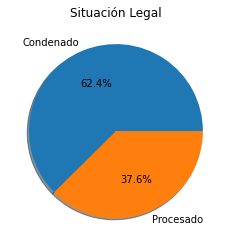

In [24]:
plt.pie(data["situacion_legal_descripcion"].value_counts(), labels=("Condenado","Procesado"), autopct="%1.1f%%", shadow=True)
plt.show
plt.title('Situación Legal')
plt.savefig("Situacion_legal.jpg")


**Establecimientos penitenciarios**

In [25]:
data_grup = data.groupby("establecimiento_descripcion")
grafico = data_grup.count()["edad"]
grafico_df = pd.DataFrame(grafico)
grafico1 =grafico.sort_values(ascending =True)

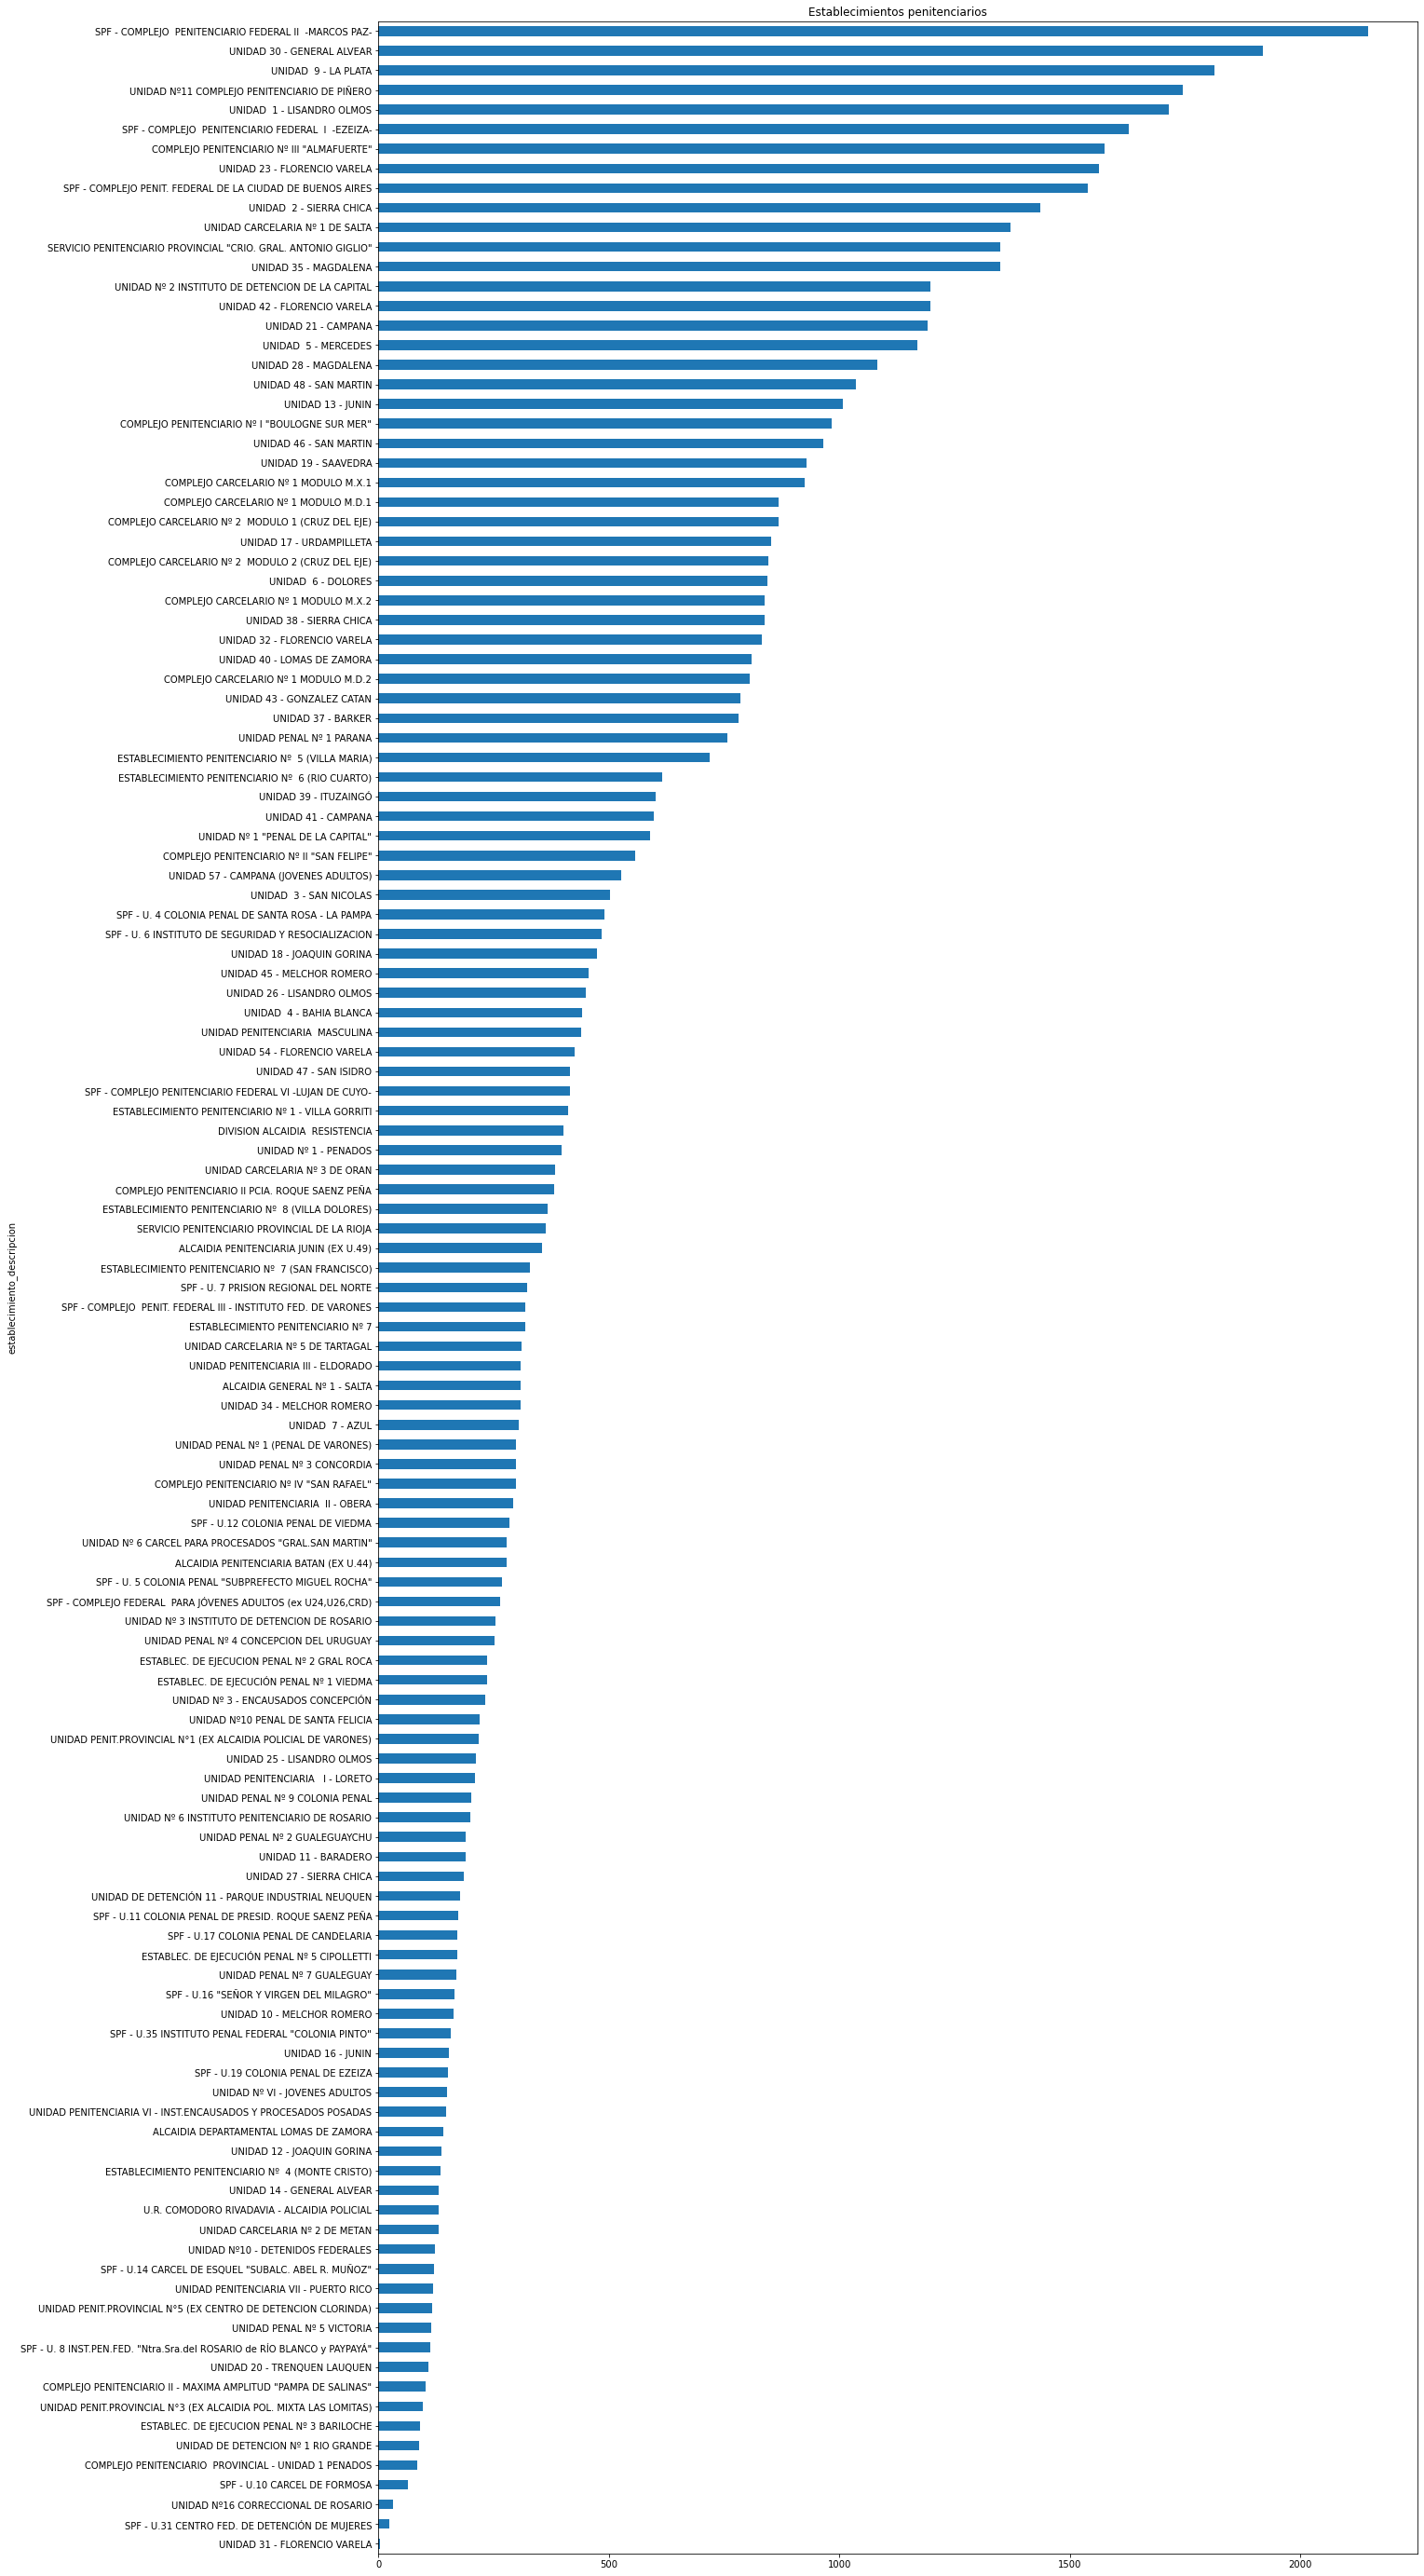

In [26]:
ax = grafico1.plot.barh(stacked=True, figsize=(20, 50))
plt.title('Establecimientos penitenciarios')
plt.savefig("Establecimientos.jpg")



**Delitos**

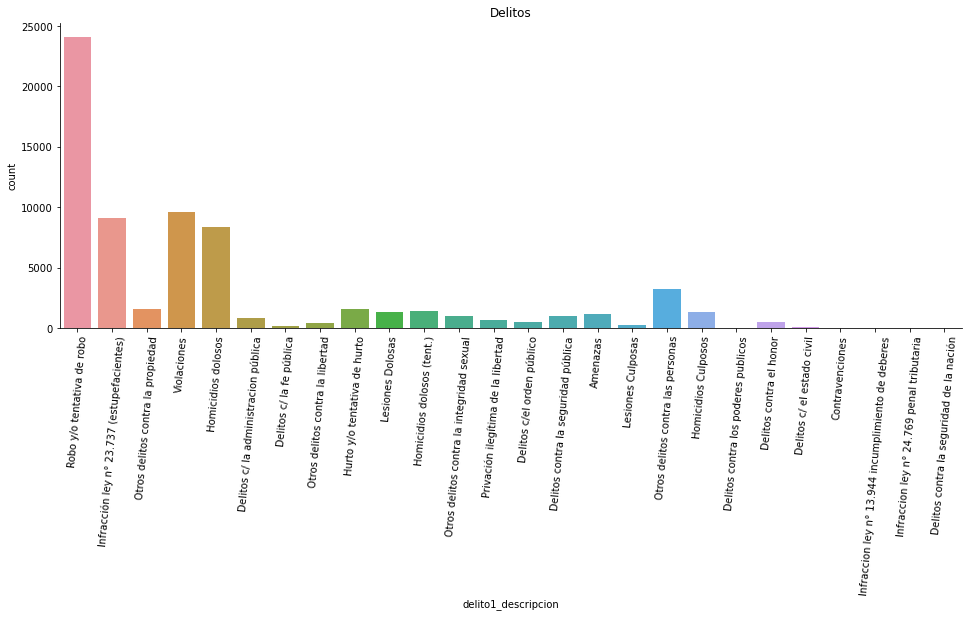

In [27]:
#fig, ax = plt.subplots(figsize = (9, 3))
g = sns.catplot(data=data, x="delito1_descripcion", kind="count", orient="h")
#g.set_xlabels('Delito',  rotation = 90)
plt.xticks(rotation=85)
g.fig.set_size_inches(30,5)
plt.title('Delitos')
plt.savefig("Delitos.jpg")


**Educación**

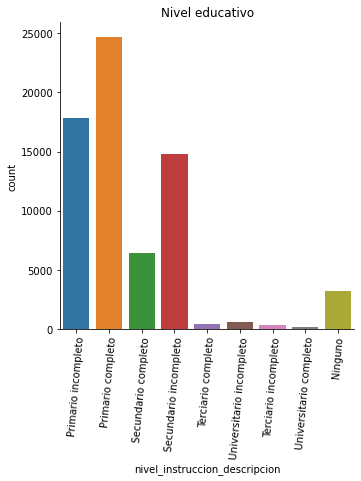

In [28]:
g = sns.catplot(data=data, x="nivel_instruccion_descripcion", kind="count")
plt.xticks(rotation=85)
plt.title('Nivel educativo')
plt.savefig("Nivel_educativo.jpg")


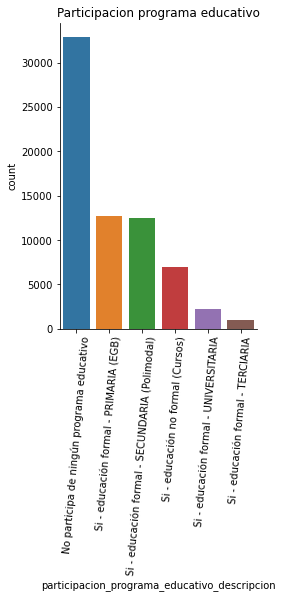

In [29]:
g = sns.catplot(data=data, x="participacion_programa_educativo_descripcion", kind="count", order =data["participacion_programa_educativo_descripcion"].value_counts().index)
plt.xticks(rotation=85)
plt.title('Participacion programa educativo')
plt.savefig("Participacion_programa_educativo.jpg")


**Calificación conducta**: Será la variable target

In [30]:
data["calificacion_conducta_descripcion"].value_counts()

Ejemplar     41265
Muy buena    13800
Buena         8309
Regular       2330
Mala          1524
Pésima        1143
Name: calificacion_conducta_descripcion, dtype: int64

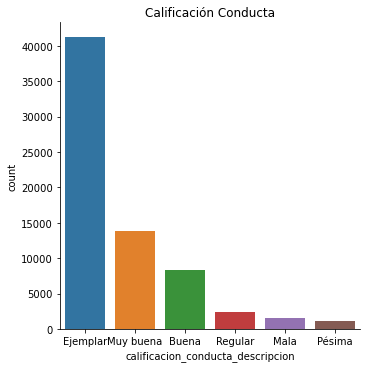

In [31]:
g = sns.catplot(data=data, x="calificacion_conducta_descripcion", kind="count", order=["Ejemplar","Muy buena","Buena", "Regular", "Mala", "Pésima"])
plt.title('Calificación Conducta')
plt.savefig("Calificacion_conducta.jpg")


Se convierte en binaria la variable target **calificacion_conducta_descripcion** con el fin de tener 2 categorías: los detenidos con mejor calificación son 0 y los de peor calificación (los posibles beneficiarios de un proyecto o programa social) son 1. 

In [32]:
y = data["calificacion_conducta_descripcion"]
y_nuevo = y.apply(lambda x: 0 if (x=="Ejemplar") | (x=="Muy buena") else 1) 

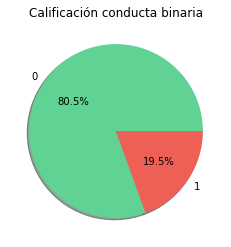

In [33]:
plt.pie(y_nuevo.value_counts(), labels=(0,1), autopct="%1.1f%%", shadow=True, colors = ["#60D394", "#EE6055"])
plt.title('Calificación conducta binaria')
plt.savefig("Conducta_target.jpg")


## Modelos de clasificación
#### Modelos PCA y K-means

Se convierte la columna **dias_detencion** a int para poder normalizarlo posteriormente.

In [34]:
import re
patron= "^(?P<dias>\d+)\s.*"  
regex = re.compile(patron)

data["dias_detencion"]= data["dias_detencion"].apply(lambda x: str(x))
data["dias_detencion"] = data["dias_detencion"].apply(lambda x: regex.search(x))
data["dias_detencion"] = data["dias_detencion"].apply(lambda x: x.group("dias"))
data["dias_detencion"] = data["dias_detencion"].apply(lambda x: np.int(x))

Se quita la columna **calificacion_conducta_descripcion** ya que será la variable target, se generan variables dummies de las categóricas y se normalizan las numéricas

In [35]:
X = data.drop(["calificacion_conducta_descripcion"], axis=1)
X_dummie=pd.get_dummies(X)
X_dummie.head(3)

,edad,participacion_programa_laboral,participacion_actividades_deportivas,recibio_visitas_ultimo_anio,tentativa_suicidio,tipo_condena,es_reincidente_descripcion,participa_programa_pre_libertad,dias_detencion,otros_delitos,...,tuvo_reduccion_pena_descripcion_Si - Hasta 6 meses,tuvo_reduccion_pena_descripcion_Si - Mas de 1 año,duracion_condena_rango_completo_12.1 a 15 años,duracion_condena_rango_completo_15.1 a 18 años,duracion_condena_rango_completo_3.1 a 6 años,duracion_condena_rango_completo_6.1 a 9 años,duracion_condena_rango_completo_9.1 a 12 años,duracion_condena_rango_completo_No condenado,duracion_condena_rango_completo_hasta 3 años,duracion_condena_rango_completo_más de 18 años
1,44,0,1,1,0,0,0,0,389,0,...,0,0,0,0,1,0,0,0,0,0
2,41,0,1,1,0,0,1,0,293,0,...,0,0,0,0,0,1,0,0,0,0
3,37,0,1,1,0,0,0,0,711,0,...,0,0,0,0,1,0,0,0,0,0


In [36]:
scaler = StandardScaler()
X_sca = scaler.fit_transform(X_dummie)


Se instancia un modelo PCA con 2 componentes principales para poder realizar una visualización.


In [37]:
pca=PCA(n_components=2)
X_pca=pca.fit_transform(X_sca)
X_pca.shape

(68371, 2)

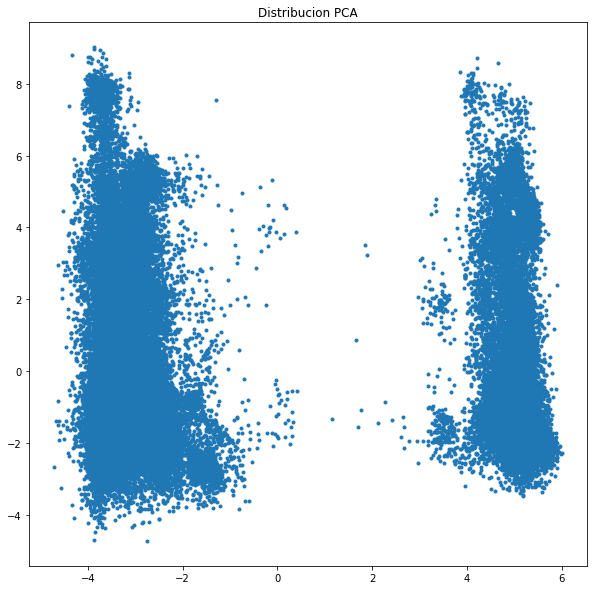

In [38]:
fig= plt.subplots(figsize = (10, 10))
plt.scatter(X_pca[:,0], X_pca[:,1], marker = '.')  
plt.title('Distribucion PCA')
plt.savefig("Distribución_PCA.jpg")


Se observan 2 cluster muy marcados por lo que se realiza un modelo de k-means a fin de observar estos datos y se grafica.

In [39]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_sca)

KMeans(n_clusters=2, random_state=42)

In [40]:
labels = kmeans.labels_ # Etiquetas que indican a qué cluster pertenecen los datos
centroids = kmeans.cluster_centers_ # Coordenadas de los centroides


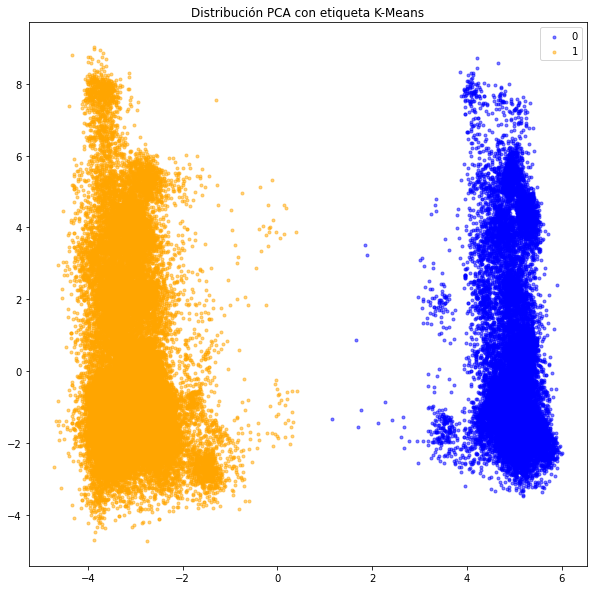

In [41]:
target_names = np.unique(labels)

colors = ['blue', 'orange']

fig= plt.subplots(figsize = (10, 10))
for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_pca[labels == i, 0],
                X_pca[labels == i, 1],
                color=color, alpha=.5, label=target_name, marker = '.')
    
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('Distribución PCA con etiqueta K-Means')
plt.savefig("Distribución_PCA.jpg")


Al revisar los datos se observa que un cluster corresponde a los detenido *Procesados* y otro a los *Condenados*. Se entiende que esto se debe, en parte, a que hay 10 variables que solo corresponen a *Detenidos*.

Se genera la visualización de los datos con las etiquetas de la variable target

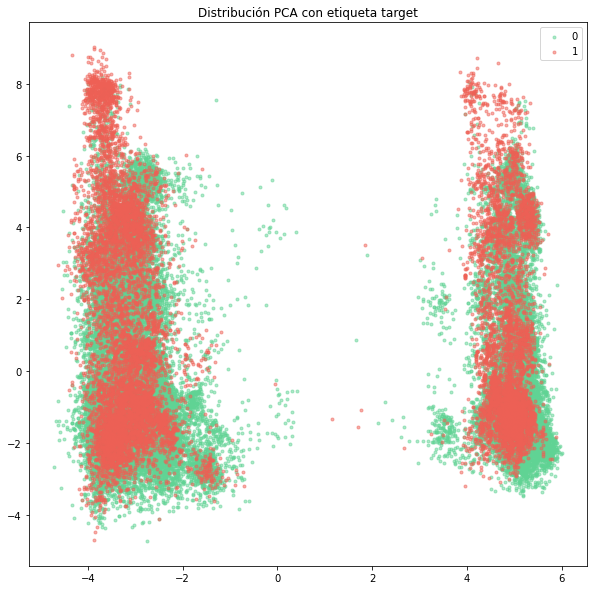

In [42]:
target_names = y_nuevo.unique()

colors = ["#60D394", "#EE6055"]

fig= plt.subplots(figsize = (10, 10))
for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_pca[y_nuevo == i, 0],
                X_pca[y_nuevo == i, 1],
                color=color, alpha=.5, label=target_name, marker = '.')

plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('Distribución PCA con etiqueta target')

plt.savefig("Distribución_target.jpg")


Se eliminan las 10 variables que solo corresponden a los detenidos *Condenado* a fin de observar la distribución de los datos. Se quitan las columnas y se realizan nuevamente todas las operaciones: generación de variables dummies, normalizacion de variables numéricas, reducción de dimensionalidad con PCA para poder realizar un gráfico y observar los datos, realización de un k-means y gráfico para observar los datos, y gráfico con etiquetas de target)

In [43]:
data_sin_ejecucion= data.drop(["tuvo_reduccion_pena_descripcion",
                               "tiene_periodo_progresividad_descripcion",
                               "tiene_periodo_progresividad_descripcion",
                               "tuvo_salidas_transitorias_descripcion",
                               "tuvo_salidas_transitorias_descripcion",
                               "participa_programa_semi_detencion_descripcion", 
                               "incorporado_reg_semi_libertad_descripcion",
                               "participa_programa_prision_discontinua_descripcion",
                               "participa_programa_pre_libertad",
                               "tipo_condena"], axis=1)
data_sin_ejecucion.shape


(68371, 29)

In [44]:
X_se = data_sin_ejecucion.drop(["calificacion_conducta_descripcion"], axis=1)
X_2=pd.get_dummies(X_se)

scaler2 = StandardScaler()
X_sca2 = scaler.fit_transform(X_2)


In [45]:
pca2=PCA(n_components=2)
X_pca2=pca2.fit_transform(X_sca2)
X_pca2.shape

(68371, 2)

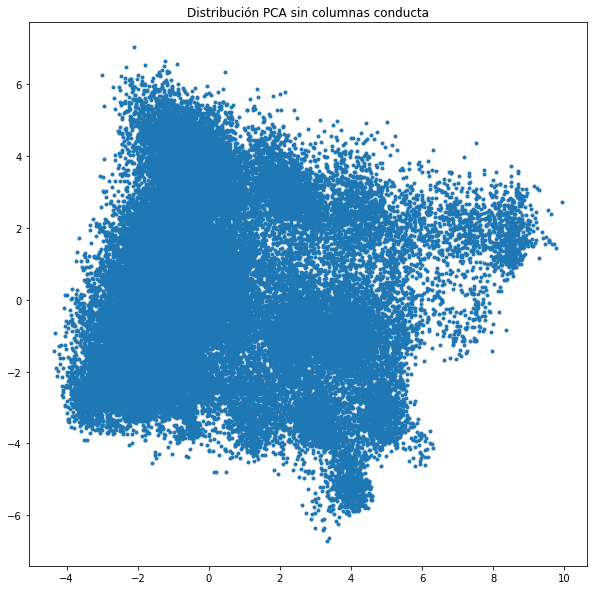

In [46]:
fig= plt.subplots(figsize = (10, 10))
plt.scatter(X_pca2[:,0], X_pca2[:,1], marker = '.')   
plt.title('Distribución PCA sin columnas conducta')
plt.savefig("Distribución_sin_variables_condena.jpg")


In [47]:
kmeans2 = KMeans(n_clusters=5)
kmeans2.fit(X_sca2)

KMeans(n_clusters=5)

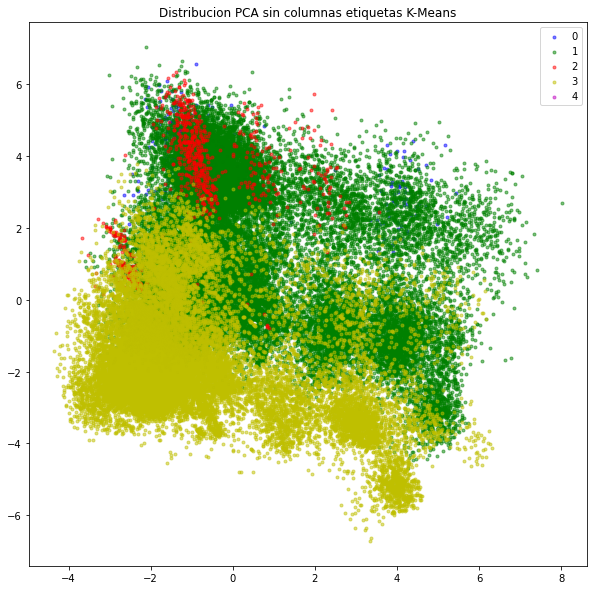

In [48]:
target_names = np.unique(kmeans2.labels_)

colors = ['b', 'g', "r", "y", "m"]

fig= plt.subplots(figsize = (10, 10))
for color, i, target_name in zip(colors, [1,2,3,4,5], target_names):
    plt.scatter(X_pca2[kmeans2.labels_ == i, 0],
                X_pca2[kmeans2.labels_ == i, 1],
                color=color, alpha=.5, label=target_name, marker = '.')
    
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('Distribucion PCA sin columnas etiquetas K-Means')

plt.savefig("Distribución_sin_variables_condena_kmeans.jpg")


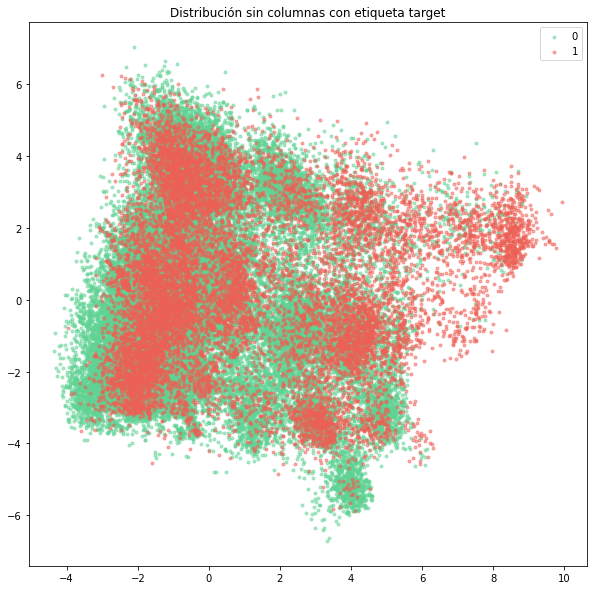

In [49]:
target_names = y_nuevo.unique()

colors = ["#60D394", "#EE6055"]

fig= plt.subplots(figsize = (10, 10))
for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_pca2[y_nuevo == i, 0],
                X_pca2[y_nuevo == i, 1],
                color=color, alpha=.5, label=target_name, marker = '.')
    
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('Distribución sin columnas con etiqueta target')

plt.savefig("Distribución_sin_variables_condena_target.jpg")


#### Condenados y Procesados
Se divide el dataset en **situacion_legal_descripcion** *Condenado* y *Procesado* y realiza nuevamente el gráfico en dos dimensiones de los componentes principales de PCA.

In [50]:
mask_procesados=data["situacion_legal_descripcion"]=="Procesado"
data_procesados = data[mask_procesados]
mask_condenados=data["situacion_legal_descripcion"]=="Condenado"
data_condenados = data[mask_condenados]


In [51]:
print(data.shape)
print(data_procesados.shape)
print(data_condenados.shape)

(68371, 37)
(25700, 37)
(42671, 37)


##### Condenados
Se quita la columna **calificacion_conducta_descripcion** ya que será la variable target, se generan variables dummies de las categóricas y se normalizan las numéricas. Luego se realiza la reducción de dimensionalidad con PCA y se realiza el gráfico correspondiente con las etiquetas que se desea clasificar.

In [52]:
X_condenados = data_condenados.drop(["calificacion_conducta_descripcion"], axis=1)
X_dummie_condenados=pd.get_dummies(X_condenados)
X_dummie_condenados.head(3)

,edad,participacion_programa_laboral,participacion_actividades_deportivas,recibio_visitas_ultimo_anio,tentativa_suicidio,tipo_condena,es_reincidente_descripcion,participa_programa_pre_libertad,dias_detencion,otros_delitos,...,tuvo_reduccion_pena_descripcion_Si - Hasta 6 meses,tuvo_reduccion_pena_descripcion_Si - Mas de 1 año,duracion_condena_rango_completo_12.1 a 15 años,duracion_condena_rango_completo_15.1 a 18 años,duracion_condena_rango_completo_3.1 a 6 años,duracion_condena_rango_completo_6.1 a 9 años,duracion_condena_rango_completo_9.1 a 12 años,duracion_condena_rango_completo_No condenado,duracion_condena_rango_completo_hasta 3 años,duracion_condena_rango_completo_más de 18 años
1,44,0,1,1,0,0,0,0,389,0,...,0,0,0,0,1,0,0,0,0,0
2,41,0,1,1,0,0,1,0,293,0,...,0,0,0,0,0,1,0,0,0,0
3,37,0,1,1,0,0,0,0,711,0,...,0,0,0,0,1,0,0,0,0,0


In [53]:
y_condenados = data_condenados["calificacion_conducta_descripcion"]
y_nuevo_condenados = y_condenados.apply(lambda x: 0 if (x=="Ejemplar") | (x=="Muy buena") else 1)
y_nuevo_condenados.shape

(42671,)

In [54]:
scaler_condenados = StandardScaler()
X_sca_condenados = scaler_condenados.fit_transform(X_dummie_condenados)
X_sca_condenados.shape

(42671, 332)

In [55]:
pca_condenados=PCA(n_components=2)
X_pca_condenados=pca_condenados.fit_transform(X_sca_condenados)
X_pca_condenados.shape

(42671, 2)

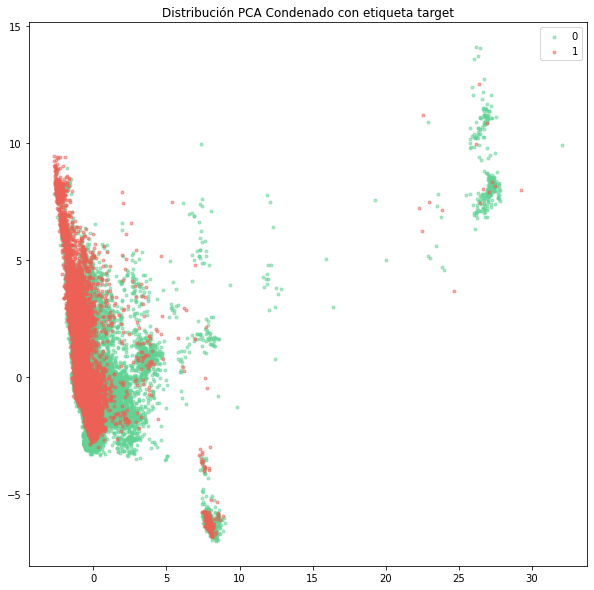

In [56]:
target_names = np.unique(y_nuevo_condenados)

colors = ["#60D394", "#EE6055"]

fig= plt.subplots(figsize = (10, 10))
for color, i, target_name in zip(colors, [0,1], target_names):
    plt.scatter(X_pca_condenados[y_nuevo_condenados == i, 0],
                X_pca_condenados[y_nuevo_condenados == i, 1],
                color=color, alpha=.5, label=target_name, marker = '.')
    
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('Distribución PCA Condenado con etiqueta target')

plt.savefig("Distribución_condenados_target.jpg")


##### Procesados
Se eliminan las columnas que solo corresponden a la categoría *Condenados*, luego la columna **calificacion_conducta_descripcion** ya que será la variable target, se generan variables dummies de las categóricas y se normalizan las numéricas. Luego se realiza la reducción de dimensionalidad con PCA y se realiza el gráfico correspondiente con las etiquetas que se desea clasificar.

In [57]:
data_procesados.drop(["tuvo_reduccion_pena_descripcion",
                               "tiene_periodo_progresividad_descripcion",
                               "tiene_periodo_progresividad_descripcion",
                               "tuvo_salidas_transitorias_descripcion",
                               "tuvo_salidas_transitorias_descripcion",
                               "participa_programa_semi_detencion_descripcion", 
                               "incorporado_reg_semi_libertad_descripcion",
                               "participa_programa_prision_discontinua_descripcion",
                               "participa_programa_pre_libertad",
                               "tipo_condena"], axis=1)

data_procesados.shape

(25700, 37)

In [58]:
X_procesados = data_procesados.drop(["calificacion_conducta_descripcion"], axis=1)
X_dummie_procesados=pd.get_dummies(X_procesados)
X_dummie_procesados.shape

(25700, 290)

In [59]:
y_procesados = data_procesados["calificacion_conducta_descripcion"]
y_nuevo_procesados = y_procesados.apply(lambda x: 0 if (x=="Ejemplar") | (x=="Muy buena") else 1)
y_nuevo_procesados.shape

(25700,)

In [60]:
scaler = StandardScaler()
X_sca_procesados = scaler.fit_transform(X_dummie_procesados)
X_sca_procesados.shape

(25700, 290)

In [61]:
pca_procesados=PCA(n_components=2)
X_pca_procesados=pca_procesados.fit_transform(X_sca_procesados)
X_pca_procesados.shape

(25700, 2)

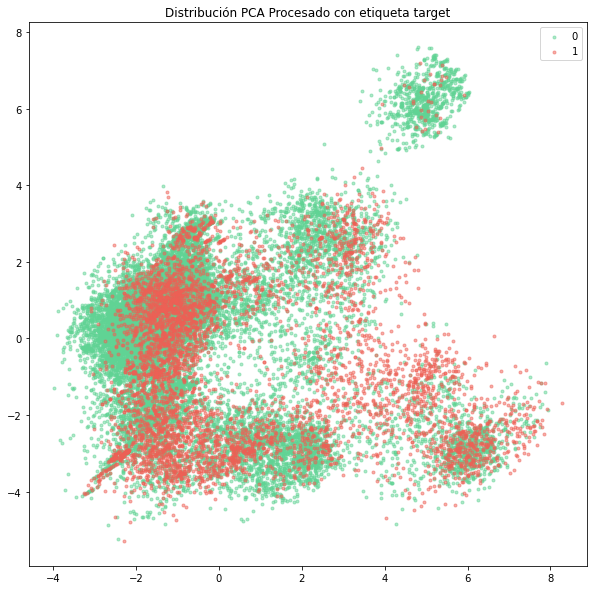

In [62]:
target_names = np.unique(y_nuevo_procesados)

colors = ["#60D394", "#EE6055"]

fig= plt.subplots(figsize = (10, 10))
for color, i, target_name in zip(colors, [0,1], target_names):
    plt.scatter(X_pca_procesados[y_nuevo_procesados == i, 0],
                X_pca_procesados[y_nuevo_procesados == i, 1],
                color=color, alpha=.5, label=target_name , marker = '.')
    
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('Distribución PCA Procesado con etiqueta target')

plt.savefig("Distribución_procesados_target.jpg")


## Modelos de clasificación

Se generarán diversos modelos para poder clasificar la variable target: **calificacion_conducta_descripcion** con 2 categorías. Se usaran distintas métricas para medir la performance de los modelos, utilizando principamente *Recall* debido a que el objetivo es identificar posibles beneficiarios de un Programa de asistencia a personas privadas de la libertad usando como criterio que tengan una calificación de conducta "Baja", "Regular", "Mala" o "Pésima" por lo cual la prioridad es que el modelo pueda identificar correctamente a todos los registros de la clase 1, aún identificando de más.

In [63]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, recall_score


Se generan 2 funciones: evaluate_model para evaluar modelos buscando hiperparámetros con grid_CV y evaluate_model_bagging para evaluar modelos de Bagging usando los mejores hiperpámetros del modelo anterior.

In [64]:
def evaluate_model(modelo, X_train, y_train, X_test, y_test, gridSearch_params):
        
    grid_CV = GridSearchCV(modelo, gridSearch_params, n_jobs=-1, cv = cv, scoring="recall")    
    grid_CV.fit(X_train, y_train)        
    scores_grid_CV = cross_val_score(modelo, X_train, y_train, cv=cv, n_jobs=-1)
    mean_score_grid_CV = scores_grid_CV.mean()
    std_score_grid_CV = scores_grid_CV.std()    
    
    best_score_grid_CV = grid_CV.best_score_
    params_grid_CV = grid_CV.best_params_
    score_grid_CV_test = grid_CV.score(X_test, y_test)
    predictions_grid_CV = grid_CV.predict(X_test)
    confusion_matrix_grid_CV = metrics.confusion_matrix(y_test, predictions_grid_CV)
    
    result = {
        'grid_cv': {
            'mean_score_grid': mean_score_grid_CV,
            'std_score_grid': std_score_grid_CV,
            'best_score_grid_train': best_score_grid_CV,
            'score_recall_test': score_grid_CV_test,
            'confusion_matrix': confusion_matrix_grid_CV,
            "best_params": params_grid_CV
            
        }
        
    }
    
    return result
        

In [65]:
def evaluate_model_ensable(estimador, X_train, y_train, X_test, y_test, gridSearch_bagging_params):
    grid_search_bagging = GridSearchCV(BaggingClassifier(base_estimator = estimador),
                                       gridSearch_bagging_params, n_jobs=-1, cv = cv)

    grid_search_bagging.fit(X_train, y_train)
    scores_bagging = cross_val_score(BaggingClassifier(base_estimator = estimador), X_train, y_train, cv=cv, n_jobs=-1, scoring="recall")
    mean_score_bagging = scores_bagging.mean()
    std_score_bagging = scores_bagging.std()    
        
    best_score_bagging_train = grid_search_bagging.best_score_
    best_params_bagging = grid_search_bagging.best_params_
        
    score_recall_test = grid_search_bagging.score(X_test, y_test)
    predictions_bagging = grid_search_bagging.predict(X_test)
    confusion_matrix_bagging = metrics.confusion_matrix(y_test, predictions_bagging)
    
    result = {
        'bagging': {
            'mean_score_grid': mean_score_bagging,
            'std_score_grid': std_score_bagging,
            'best_score_grid_train': best_score_bagging_train,
            'score_recall_test': score_recall_test,
            'confusion_matrix': confusion_matrix_bagging, 
            "best_params": best_params_bagging

            
        }
        
    }
    
    return result
        
    


Se instancia los folds de Cross Validation y se divide el dataset en train y test. 

In [66]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=371)


In [67]:
X_train, X_test, y_train, y_test = train_test_split(X_sca, y_nuevo, test_size=0.3, random_state=42, stratify=y_nuevo)


**Árbol de decisión**

In [125]:
modelo = DecisionTreeClassifier(random_state=135)
gridSearch_params = {'criterion': ['gini', 'entropy'],
          'splitter': ['best', 'random'],
          'max_depth': [None, 5, 10],
          'min_samples_split': [2, 5],
          'min_samples_leaf': [1, 2, 3]}


decision_tree_metrics = evaluate_model(modelo, X_train, y_train, X_test, y_test, gridSearch_params)
display(pd.DataFrame.from_dict(decision_tree_metrics))


,grid_cv
best_params,"{'criterion': 'gini', 'max_depth': None, 'min_..."
best_score_grid_train,0.575262
confusion_matrix,"[[14756, 1764], [1654, 2338]]"
mean_score_grid,0.828517
score_recall_test,0.585671
std_score_grid,0.000515215


**Regresión Logística**

In [69]:
modelo = LogisticRegression(solver='lbfgs', max_iter=200)
gridSearch_params_lr = {'C': [0.001, 0.01, 0.1, 1.0, 10.0], 'penalty': ['l1', 'l2']}

logistic_metrics = evaluate_model(modelo, X_train, y_train, X_test, y_test, gridSearch_params_lr)

df_logistic_metrics=pd.DataFrame.from_dict(logistic_metrics)
display(df_logistic_metrics)

C:\Users\Valeria\Anaconda3\envs\dhdsblend\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan 0.41560963        nan 0.45243614        nan 0.46102541
        nan 0.46166956        nan 0.46166956]
  category=UserWarning
C:\Users\Valeria\Anaconda3\envs\dhdsblend\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,grid_cv
best_params,"{'C': 1.0, 'penalty': 'l2'}"
best_score_grid_train,0.46167
confusion_matrix,"[[15920, 600], [2197, 1795]]"
mean_score_grid,0.861531
score_recall_test,0.449649
std_score_grid,0.00112599


**KNN**

In [70]:
modelo = KNeighborsClassifier()
gridSearch_params_knn = {'n_neighbors': range(1,3)}
knn_metrics = evaluate_model(modelo,  X_train, y_train, X_test, y_test, gridSearch_params_knn)

df_knn_metrics =pd.DataFrame.from_dict(knn_metrics)
display(df_knn_metrics)


,grid_cv
best_params,{'n_neighbors': 1}
best_score_grid_train,0.534678
confusion_matrix,"[[14659, 1861], [1852, 2140]]"
mean_score_grid,0.851439
score_recall_test,0.536072
std_score_grid,0.000534349


Se utiliza la funcion evaluate_model_ensamble para generar un **Modelo Bagging** con un Árbol de decisión (el que performa mejor de los tres modelos probados anteriormente) con los hiperparámetros seleccionados en el GridSearch.

In [127]:
gridSearch_bagging_params = {'n_estimators': [10, 100],
                  'max_samples': [0.01, 1.0],                  
                  'max_features': [0.3, 1.0],                  
                  'bootstrap_features': [True, False]}

estimador=DecisionTreeClassifier(criterion= 'gini', max_depth= None, min_samples_leaf= 1,min_samples_split= 2,splitter= 'best')
bagging_metrics_tree = evaluate_model_ensable(estimador, X_train, y_train, X_test, y_test, gridSearch_bagging_params)
df_bagging_metrics_tree=pd.DataFrame.from_dict(bagging_metrics_tree)
display(df_bagging_metrics_tree)

,bagging
best_params,"{'bootstrap_features': False, 'max_features': ..."
best_score_grid_train,0.882509
confusion_matrix,"[[15835, 685], [1636, 2356]]"
mean_score_grid,0.536074
score_recall_test,0.886847
std_score_grid,0.00808342


**Random Forest**

In [72]:
modelo = RandomForestClassifier()
gridSearch_params_rm = {'n_estimators':[3, 5, 10, 50],
          'criterion': ['gini', 'entropy'],
          'max_depth': [None, 3, 5],
          'min_samples_split': [2,5],
          'class_weight':[None, 'balanced']}


random_forest_metrics = evaluate_model(modelo, X_train, y_train, X_test, y_test, gridSearch_params_rm)
df_random_forest_metrics= pd.DataFrame.from_dict(random_forest_metrics)
display(df_random_forest_metrics)



,grid_cv
best_params,"{'class_weight': 'balanced', 'criterion': 'ent..."
best_score_grid_train,0.687567
confusion_matrix,"[[13244, 3276], [1551, 2441]]"
mean_score_grid,0.87927
score_recall_test,0.611473
std_score_grid,0.00172884


Se genera un Dataframe de resumen de los resultados de *Recall* y se grafica

In [129]:
all_model_metrics = [decision_tree_metrics,
                     logistic_metrics, 
                     knn_metrics, 
                     bagging_metrics_tree,
                     random_forest_metrics]

all_model_names =  ["arbol",
                    "regresión_logistica",
                    "knn",
                    "arbol_bagging",
                    "random_forest"]

data_recall = pd.DataFrame(columns = ['model', 'recall'])

data_recall
for i in range(len(all_model_names)):
    model_name_prefix = all_model_names[i]
    model_metric = all_model_metrics[i]        
    for model_metric_key in model_metric.keys():    
        recall = model_metric[model_metric_key]['score_recall_test']        
        data_recall = data_recall.append({'model': model_name_prefix, 'recall':recall}, ignore_index=True)
        

data_recall.sort_values(by = 'recall', axis=0, ascending=True, inplace=True)
data_recall

,model,recall
1,regresión_logistica,0.449649
2,knn,0.536072
0,arbol,0.585671
4,random_forest,0.611473
3,arbol_bagging,0.886847


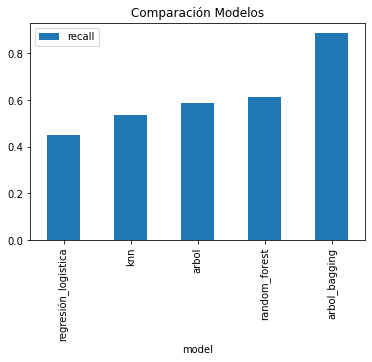

In [130]:
data_recall.plot(x= "model", y="recall", kind='bar')
plt.title('Comparación Modelos')
plt.savefig("Evaluación_modelos.jpg")


#### Desbalanceo de la clase target
Debido a que la clase que se intenta clasificar se encuentra desbalanceada, se realizará un **Under Sampling** y se probarán los modelos nuevamente.

In [75]:
from imblearn.under_sampling import RandomUnderSampler


undersampler=RandomUnderSampler(sampling_strategy='majority');

X_train_us,y_train_us=undersampler.fit_resample(X_train,y_train);

print('Composición del training set:')
print(y_train_us.value_counts())

print('\nComposición del test set:')
print(y_test.value_counts())

Composición del training set:
1    9314
0    9314
Name: calificacion_conducta_descripcion, dtype: int64

Composición del test set:
0    16520
1     3992
Name: calificacion_conducta_descripcion, dtype: int64


**Árbol de decisión con clases balanceadas**

In [131]:
modelo = DecisionTreeClassifier(random_state=135)
gridSearch_params = {'criterion': ['gini', 'entropy'],
          'splitter': ['best', 'random'],
          'max_depth': [None, 5, 10],
          'min_samples_split': [2, 5],
          'min_samples_leaf': [1, 2, 3]}


tree_balanceada = evaluate_model(modelo, X_train_us, y_train_us, X_test, y_test, gridSearch_params)

df_tree_balanceada =pd.DataFrame.from_dict(tree_balanceada)
display(df_tree_balanceada)

,grid_cv
best_params,"{'criterion': 'entropy', 'max_depth': 10, 'min..."
best_score_grid_train,0.792141
confusion_matrix,"[[11268, 5252], [675, 3317]]"
mean_score_grid,0.746833
score_recall_test,0.830912
std_score_grid,0.00450364


**Regresión Logística con clases balanceadas**

In [77]:
modelo = LogisticRegression(solver='lbfgs', max_iter=200)
gridSearch_params_lr = {'C': [0.001, 0.01, 0.1, 1.0, 10.0], 'penalty': ['l1', 'l2']}

logistic_balanceadas = evaluate_model(modelo, X_train_us, y_train_us, X_test, y_test, gridSearch_params_lr)

df_logistic_balanc=pd.DataFrame.from_dict(logistic_balanceadas)
display(df_logistic_balanc)

C:\Users\Valeria\Anaconda3\envs\dhdsblend\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan 0.74457829        nan 0.76057545        nan 0.76347445
        nan 0.76390393        nan 0.76368923]
  category=UserWarning
C:\Users\Valeria\Anaconda3\envs\dhdsblend\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,grid_cv
best_params,"{'C': 1.0, 'penalty': 'l2'}"
best_score_grid_train,0.763904
confusion_matrix,"[[13109, 3411], [945, 3047]]"
mean_score_grid,0.773943
score_recall_test,0.763277
std_score_grid,0.00295288


**KNN con clases balanceadas**

In [78]:
modelo = KNeighborsClassifier()
gridSearch_params_knn = {'n_neighbors': range(1,10)}
knn_metrics_balanc = evaluate_model(modelo,  X_train_us, y_train_us, X_test, y_test, gridSearch_params_knn)

df_knn_balanc =pd.DataFrame.from_dict(knn_metrics_balanc)
display(df_knn_balanc)


,grid_cv
best_params,{'n_neighbors': 7}
best_score_grid_train,0.77303
confusion_matrix,"[[12485, 4035], [895, 3097]]"
mean_score_grid,0.755798
score_recall_test,0.775802
std_score_grid,0.00356202


**Bagging de Árbol de decisión con clases balanceadas**

In [133]:
gridSearch_bagging_params = {'n_estimators': [10, 100],
                  'max_samples': [0.01, 1.0],                  
                  'max_features': [0.3, 1.0],                  
                  'bootstrap_features': [True, False]}

estimador=DecisionTreeClassifier(criterion='entropy',
                                 max_depth= 10,
                                 min_samples_leaf = 3,
                                 min_samples_split= 2,
                                 splitter= 'best')

bagging_balanc_tree = evaluate_model_ensable(estimador, X_train_us, y_train_us, X_test, y_test, gridSearch_bagging_params)
df_bagging_balanc_tree=pd.DataFrame.from_dict(bagging_balanc_tree)
display(df_bagging_balanc_tree)

,bagging
best_params,"{'bootstrap_features': True, 'max_features': 1..."
best_score_grid_train,0.795362
confusion_matrix,"[[13435, 3085], [878, 3114]]"
mean_score_grid,0.786449
score_recall_test,0.806796
std_score_grid,0.012047


**Random Forest con clases balanceadas**

In [134]:
modelo = RandomForestClassifier()
gridSearch_params_rm = {'n_estimators':[3, 5, 10, 50],
          'criterion': ['gini', 'entropy'],
          'max_depth': [None, 3, 5],
          'min_samples_split': [2,5],
          'class_weight':[None, 'balanced']}


random_forest_balanc = evaluate_model(modelo, X_train_us, y_train_us, X_test, y_test, gridSearch_params_rm)
df_random_forest_balanc= pd.DataFrame.from_dict(random_forest_balanc)
display(df_random_forest_balanc)



,grid_cv
best_params,"{'class_weight': None, 'criterion': 'entropy',..."
best_score_grid_train,0.798583
confusion_matrix,"[[13624, 2896], [805, 3187]]"
mean_score_grid,0.810071
score_recall_test,0.798347
std_score_grid,0.00733084


Se realizá una tabla de resumen de *Recall* en cada modelo, se une con el resumen de los modelos anteriores y se gráfican los resultados.

In [135]:
all_model_metrics = [tree_balanceada,
                     logistic_balanceadas, 
                     knn_metrics_balanc,
                     bagging_balanc_tree,                     
                     random_forest_balanc]

all_model_names =  ["arbol_balanceada",
                    'regresión_logistica_balanceada',
                    'knn_balanceada',
                    "arbol_bagging_balanceada",
                    'random_forest_balanceada']

data_resumen_balanc = pd.DataFrame(columns = ['model', 'recall'])

data_resumen_balanc
for i in range(len(all_model_names)):
    model_name_prefix = all_model_names[i]
    model_metric = all_model_metrics[i]        
    for model_metric_key in model_metric.keys():    
        recall = model_metric[model_metric_key]['score_recall_test']        
        data_resumen_balanc = data_resumen_balanc.append({'model': model_name_prefix, 'recall':recall}, ignore_index=True)
        

data_resumen_balanc.sort_values(by = 'recall', axis=0, ascending=True, inplace=True)
data_resumen_balanc

,model,recall
1,regresión_logistica_balanceada,0.763277
2,knn_balanceada,0.775802
4,random_forest_balanceada,0.798347
3,arbol_bagging_balanceada,0.806796
0,arbol_balanceada,0.830912


In [136]:
data_resumen = pd.concat([data_recall, data_resumen_balanc])
data_resumen.sort_values(by = 'recall', axis=0, ascending=True, inplace=True)
data_resumen

,model,recall
1,regresión_logistica,0.449649
2,knn,0.536072
0,arbol,0.585671
4,random_forest,0.611473
1,regresión_logistica_balanceada,0.763277
2,knn_balanceada,0.775802
4,random_forest_balanceada,0.798347
3,arbol_bagging_balanceada,0.806796
0,arbol_balanceada,0.830912
3,arbol_bagging,0.886847


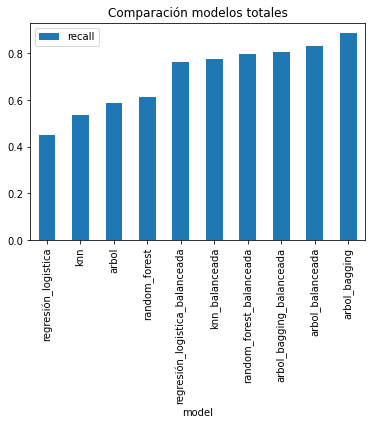

In [137]:
data_resumen.plot(x= "model", y="recall", kind='bar')
plt.title('Comparación modelos totales')
plt.savefig("Evaluación_modelos_balanceados.jpg")

### Modelo Árbol Bagging

El modelo que mejor performa es el **Modelo de  Árbol Bagging** sin las clases balanceadas de la siguiente manera: 

El estimador es un Árbol con hiperpámetros criterion: 'gini', max_depth: None, min_samples_leaf: 1,min_samples_split: 2,splitter: 'best' y los hiperparametros son bootstrap_features:True, max_features:1.0, max_samples: 1.0 y n_estimators:  100 con un *Recall* de 0.89. Se grafica la distribución resultante en dos dimensiones para poder realizar la comparación con los datos originales. 

In [84]:
modelo_ab = BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion= 'gini', max_depth= None, min_samples_leaf= 1,min_samples_split= 2,splitter= 'best'),
                              bootstrap_features = True, max_features= 1.0, max_samples= 1.0, n_estimators= 100, random_state=135)

modelo_ab.fit(X_train, y_train)


BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                  bootstrap_features=True, n_estimators=100, random_state=135)

In [85]:
y_pred_ab = modelo_ab.predict(X_sca)
y_pred_ab

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

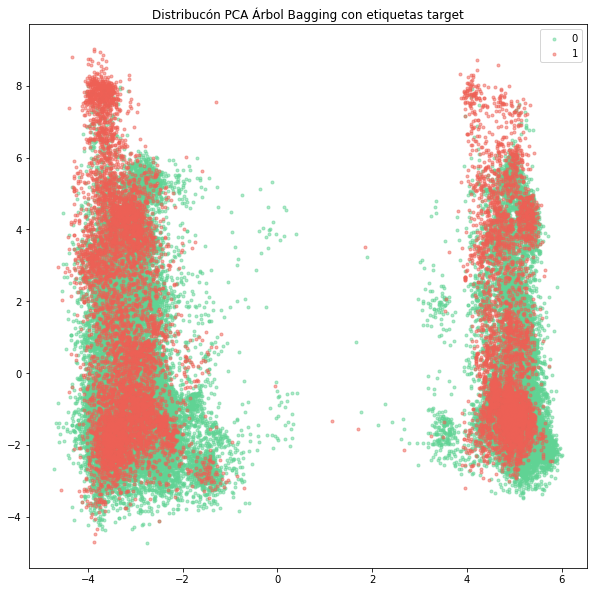

In [86]:
target_names = np.unique(y_pred_ab)

colors = ["#60D394", "#EE6055"]

fig= plt.subplots(figsize = (10, 10))
for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_pca[y_pred_ab == i, 0],
                X_pca[y_pred_ab == i, 1],
                color=color, alpha=.5, label=target_name, marker=".")

plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('Distribucón PCA Árbol Bagging con etiquetas target')

plt.savefig("Distribución_Árbol Bagging.jpg")

### Diferencia entre Procesados y Condenados

En la exploración de los datos se observó que se generan dos grandes clausters dividido por la **situacion_legal_descripcion**, personas privadas de su libertad *Condenado* y *Procesado*. Se retoma la división del dataset y se prueba el modelo de Ábrol Bagging en cada una de esas categorías. 

#### Condenados

Se divide en train y test, y se utiliza la función anterior para entrenar un modelo Árbol Bagging con disintos hiperparámetros (los parámetros del estimador son los del Árbol que mejor performance tuvo). Por último se grafican en dos dimensiones (PCA) los resultados para poder realizar una comparación visual.

In [87]:
X_train_condenados, X_test_condenados, y_train_condenados, y_test_condenados = train_test_split(X_sca_condenados, y_nuevo_condenados, test_size=0.3, random_state=42, stratify=y_nuevo_condenados)

In [88]:
gridSearch_bagging_params = {'n_estimators': [10, 100],
                  'max_samples': [0.01, 1.0],                  
                  'max_features': [0.3, 1.0],                  
                  'bootstrap_features': [True, False]}

estimador=DecisionTreeClassifier(criterion= 'gini', max_depth= None, min_samples_leaf= 1,min_samples_split= 2,splitter= 'best')
bagging_metrics_tree_condenados = evaluate_model_ensable(estimador, X_train_condenados, y_train_condenados, X_test_condenados, y_test_condenados, gridSearch_bagging_params)
df_bagging_metrics_tree_condenados=pd.DataFrame.from_dict(bagging_metrics_tree_condenados)
display(df_bagging_metrics_tree_condenados)

,bagging
best_params,"{'bootstrap_features': True, 'max_features': 1..."
best_score_grid_train,0.882587
confusion_matrix,"[[10087, 351], [1087, 1277]]"
mean_score_grid,0.499003
score_recall_test,0.887674
std_score_grid,0.00419642


In [89]:
modelo_ab_condenados = BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion= 'gini', max_depth= None, min_samples_leaf= 1,min_samples_split= 2,splitter= 'best'),
                                          bootstrap_features =True, max_features= 1.0, max_samples= 1.0, n_estimators= 100, random_state=135)
modelo_ab_condenados.fit(X_train_condenados, y_train_condenados)


BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                  bootstrap_features=True, n_estimators=100, random_state=135)

In [90]:
y_pred_condenados_ab = modelo_ab_condenados.predict(X_sca_condenados)
y_pred_condenados_ab

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [91]:
pca_condenados=PCA(n_components=2)
X_pca_condenados=pca_condenados.fit_transform(X_sca_condenados)
X_pca_condenados.shape

(42671, 2)

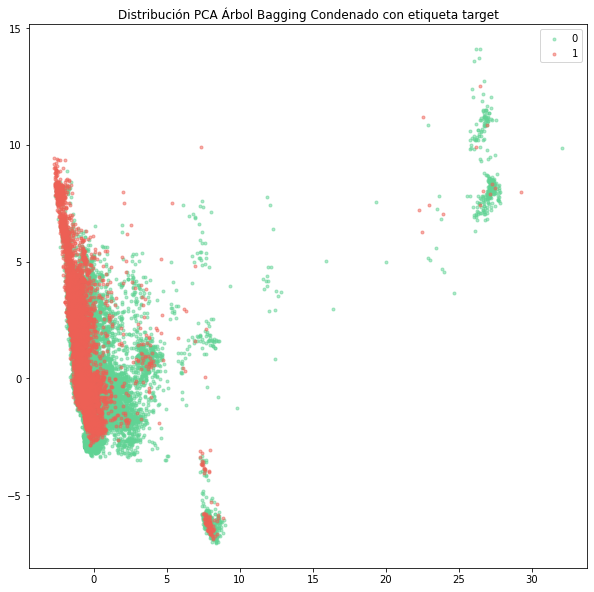

In [92]:
target_names = np.unique(y_pred_condenados_ab)

colors = ["#60D394", "#EE6055"]

fig= plt.subplots(figsize = (10, 10))
for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_pca_condenados[y_pred_condenados_ab == i, 0],
                X_pca_condenados[y_pred_condenados_ab == i, 1],
                color=color, alpha=.5, label=target_name, marker=".")

plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('Distribución PCA Árbol Bagging Condenado con etiqueta target')


plt.savefig("Distribución_Árbol_Bagging_condenados.jpg")

#### Procesados

Se divide en train y test, y se utiliza la función anterior para entrenar un modelo Árbol Bagging con disintos hiperparámetros (los parámetros del estimador son los del Árbol que mejor performance tuvo). Por último se grafican en dos dimensiones (PCA) los resultados para poder realizar una comparación visual.

In [93]:
X_train_procesados, X_test_procesados, y_train_procesados, y_test_procesados = train_test_split(X_sca_procesados, y_nuevo_procesados, test_size=0.3, random_state=42, stratify=y_nuevo_procesados)

In [94]:
gridSearch_bagging_params = {'n_estimators': [10, 100],
                  'max_samples': [0.01, 1.0],                  
                  'max_features': [0.3, 1.0],                  
                  'bootstrap_features': [True, False]}

estimador=DecisionTreeClassifier(criterion= 'gini', max_depth= None, min_samples_leaf= 1,min_samples_split= 2,splitter= 'best')
bagging_metrics_tree_procesados = evaluate_model_ensable(estimador, X_train_procesados, y_train_procesados, X_test_procesados, y_test_procesados, gridSearch_bagging_params)
df_bagging_tree_procesados=pd.DataFrame.from_dict(bagging_metrics_tree_procesados)
display(df_bagging_tree_procesados)

,bagging
best_params,"{'bootstrap_features': True, 'max_features': 1..."
best_score_grid_train,0.8811
confusion_matrix,"[[5882, 201], [742, 885]]"
mean_score_grid,0.567667
score_recall_test,0.877691
std_score_grid,0.0142229


In [95]:
modelo_ab_procesados = BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion= 'gini', max_depth= None, min_samples_leaf= 1,min_samples_split= 2,splitter= 'best'),
                                          bootstrap_features =True, max_features= 1.0, max_samples= 1.0, n_estimators= 100, random_state=135)

modelo_ab_procesados.fit(X_train_procesados, y_train_procesados)


BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                  bootstrap_features=True, n_estimators=100, random_state=135)

In [96]:
y_pred_procesados_ab = modelo_ab_procesados.predict(X_sca_procesados)
y_pred_procesados_ab

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [97]:
pca_procesados=PCA(n_components=2)
X_pca_procesados=pca_procesados.fit_transform(X_sca_procesados)
X_pca_procesados.shape

(25700, 2)

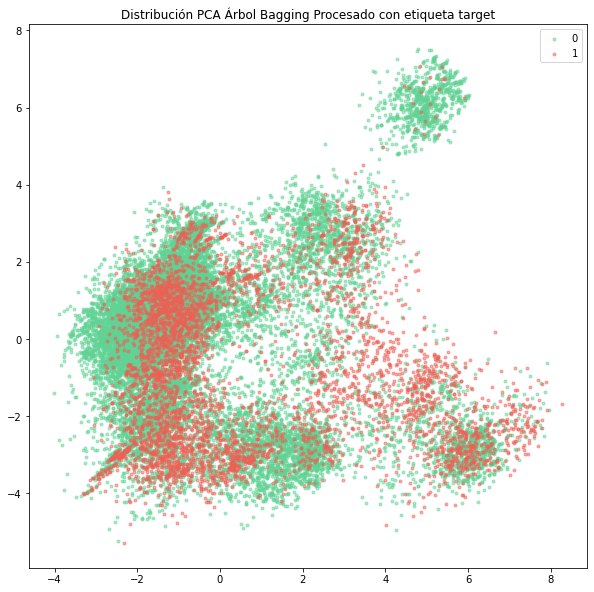

In [98]:
target_names = np.unique(y_pred_procesados_ab)

colors = ["#60D394", "#EE6055"]

fig= plt.subplots(figsize = (10, 10))
for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_pca_procesados[y_pred_procesados_ab == i, 0],
                X_pca_procesados[y_pred_procesados_ab == i, 1],
                color=color, alpha=.5, label=target_name, marker=".")

plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('Distribución PCA Árbol Bagging Procesado con etiqueta target')


plt.savefig("Distribución_Árbol_Bagging_procesado.jpg")

## Resumén tres modelos generados

Se generaron tres modelos de Bagging de Árboles con los siguientes hiperparámetros del Árbol estimador: criterion: 'gini', max_depth: None, min_samples_leaf: 1, min_samples_split: 2, splitter: 'best'. De los modelos de Bagging:

**Dataset completo**: hiperparametros: class_weight = 'balanced', criterion= 'entropy', max_depth= None, min_samples_split= 5, n_estimators = 50), *Recall: 0.887*

**Condenados**: hiperparametros: class_weight =None, criterion= 'entropy', max_depth= None, min_samples_split= 5,n_estimators = 50, *Recall: 0.888*

**Procesados**: hiperparametros: class_weight =None, criterion= 'gini', max_depth= None, min_samples_split= 5,n_estimators = 50, *Recall: 0.878*



In [141]:
all_model_metrics = [bagging_metrics_tree,
                     bagging_metrics_tree_condenados,
                     bagging_metrics_tree_procesados]

all_model_names =  ["data_completa_bagging",
                    'data_condenados_bagging',
                    'data_procesados_bagging']

data_resumen_final_bagging= pd.DataFrame(columns = ['model', 'recall'])

data_resumen_final_bagging
for i in range(len(all_model_names)):
    model_name_prefix = all_model_names[i]
    model_metric = all_model_metrics[i]        
    for model_metric_key in model_metric.keys():    
        recall = model_metric[model_metric_key]['score_recall_test']        
        data_resumen_final_bagging = data_resumen_final_bagging.append({'model': model_name_prefix, 'recall':recall}, ignore_index=True)
        

data_resumen_final_bagging.sort_values(by = 'recall', axis=0, ascending=True, inplace=True)
data_resumen_final_bagging

,model,recall
2,data_procesados_bagging,0.877691
0,data_completa_bagging,0.886847
1,data_condenados_bagging,0.887674


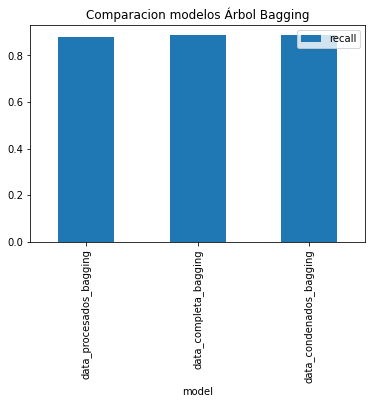

In [139]:
data_resumen_final_bagging.plot(x= "model", y="recall", kind='bar')
plt.title('Comparacion modelos Árbol Bagging')
plt.savefig("Evaluacion_modelos_final_Bagging.jpg")


### Faeture importance

Se observará el la improtancia de las variables en cada modelo para poder tener como insumo a la hora de diseñar un Programa Social de asistencia a personas privadas de su libertad.

**Data completa**

In [101]:
arbol_feature_importance_ab = [tree.feature_importances_ for tree in modelo_ab.estimators_]
importancia_arboles_base_ab = pd.DataFrame(data = arbol_feature_importance_ab)
feature_importance_calc_ab = np.mean(importancia_arboles_base_ab, axis = 0)
feature_importance_calc_ab.index = X_dummie.columns
importancia_features_ab = pd.DataFrame(feature_importance_calc_ab, columns=['importancia'])
importancia_features_sort_ab = importancia_features_ab.sort_values('importancia', ascending=False)
importancia_features_sort_ab[0:10]


,importancia
ultima_provincia_residencia_descripcion_Entre Ríos,0.007719
tiene_periodo_progresividad_descripcion_Período de libertad condicional,0.007223
establecimiento_descripcion_SPF - U. 6 INSTITUTO DE SEGURIDAD Y RESOCIALIZACION,0.006656
tuvo_salidas_transitorias_descripcion_Suspendidas durante el último año,0.006464
ultima_provincia_residencia_descripcion_La Pampa,0.006119
nacionalidad_descripcion_Argentina,0.006102
"fue_lesionado_descripcion_Si, por hechos prod. por otros internos",0.006095
jurisdiccion_descripcion_PROVINCIAL - Santa Cruz,0.006088
nivel_instruccion_descripcion_Primario completo,0.006051
tiene_periodo_progresividad_descripcion_Período de tratamiento,0.005852


**Condenados**

In [102]:
arbol_feature_importance_ab_condenados = [tree.feature_importances_ for tree in modelo_ab_condenados.estimators_]
importancia_arboles_base_ab_condenados = pd.DataFrame(data = arbol_feature_importance_ab_condenados)
feature_importance_calc_ab_condenados = np.mean(importancia_arboles_base_ab_condenados, axis = 0)
feature_importance_calc_ab_condenados.index = X_dummie_condenados.columns
importancia_features_ab_condenados = pd.DataFrame(feature_importance_calc_ab_condenados, columns=['importancia'])
importancia_features_sort_ab_condenados = importancia_features_ab.sort_values('importancia', ascending=False)
importancia_features_sort_ab_condenados[0:10]

,importancia
ultima_provincia_residencia_descripcion_Entre Ríos,0.007719
tiene_periodo_progresividad_descripcion_Período de libertad condicional,0.007223
establecimiento_descripcion_SPF - U. 6 INSTITUTO DE SEGURIDAD Y RESOCIALIZACION,0.006656
tuvo_salidas_transitorias_descripcion_Suspendidas durante el último año,0.006464
ultima_provincia_residencia_descripcion_La Pampa,0.006119
nacionalidad_descripcion_Argentina,0.006102
"fue_lesionado_descripcion_Si, por hechos prod. por otros internos",0.006095
jurisdiccion_descripcion_PROVINCIAL - Santa Cruz,0.006088
nivel_instruccion_descripcion_Primario completo,0.006051
tiene_periodo_progresividad_descripcion_Período de tratamiento,0.005852


**Procesados**

In [103]:
arbol_feature_importance_ab_procesados = [tree.feature_importances_ for tree in modelo_ab_procesados.estimators_]
importancia_arboles_base_ab_procesados = pd.DataFrame(data = arbol_feature_importance_ab_procesados)
feature_importance_calc_ab_procesados = np.mean(importancia_arboles_base_ab_procesados, axis = 0)
feature_importance_calc_ab_procesados.index = X_dummie_procesados.columns
importancia_features_ab_procesados = pd.DataFrame(feature_importance_calc_ab_procesados, columns=['importancia'])
importancia_features_sort_ab_procesados = importancia_features_ab_procesados.sort_values('importancia', ascending=False)
importancia_features_sort_ab_procesados[0:10]

,importancia
capacitacion_laboral_al_ingresar_descripcion_Tiene algún oficio,0.009209
horas_trabajo_remunerado_descripcion_Hasta 30 hs. Semanales,0.008111
capacitacion_laboral_al_ingresar_descripcion_No tiene ni oficio ni profesión,0.008093
establecimiento_descripcion_UNIDAD 21 - CAMPANA,0.008061
participacion_programa_educativo_descripcion_Si - educación formal - PRIMARIA (EGB),0.007233
sancion_aplicada_descripcion_Perm. aloj. indiv. o celda hasta 7 f/de Sem sus/al,0.007184
establecimiento_descripcion_UNIDAD Nº16 CORRECCIONAL DE ROSARIO,0.007159
establecimiento_descripcion_SPF - U.19 COLONIA PENAL DE EZEIZA,0.006937
ultimo_lugar_residencia_descripcion_Rural,0.006638
sancion_aplicada_descripcion_Exclus. de activ. recreat/dep. hasta 10 días,0.006617


Obsevamos la distribución de la variable target en las variables con mayor importancia en cada caso:


**Data completa**

In [104]:
data["calificacion_conducta_descripcion"] = data["calificacion_conducta_descripcion"].apply(lambda x: 0 if (x=="Ejemplar") | (x=="Muy buena") else 1) 

In [105]:
data["calificacion_conducta_descripcion"].value_counts(normalize=True)

0    0.805385
1    0.194615
Name: calificacion_conducta_descripcion, dtype: float64

In [106]:
mask_les= data["fue_lesionado_descripcion"]=="Si, por hechos prod. por otros internos"
data_les = data[mask_les]
data_les["calificacion_conducta_descripcion"].value_counts(normalize=True)

0    0.576936
1    0.423064
Name: calificacion_conducta_descripcion, dtype: float64

In [107]:
mask_np= data["nivel_instruccion_descripcion"]=="Primario completo"
data_np = data[mask_np]
data_np["calificacion_conducta_descripcion"].value_counts(normalize=True)

0    0.795493
1    0.204507
Name: calificacion_conducta_descripcion, dtype: float64

In [108]:
mask_er= data["ultima_provincia_residencia_descripcion"]=="Entre Ríos"
data_er = data[mask_er]
data_er["calificacion_conducta_descripcion"].value_counts(normalize=True)

0    0.770199
1    0.229801
Name: calificacion_conducta_descripcion, dtype: float64

In [109]:
mask_derivpol= data["establecimiento_procedencia_descripcion"]=="Deriv. de una instit. Policial"
data_derivpol = data[mask_derivpol]
data_derivpol["calificacion_conducta_descripcion"].value_counts(normalize=True)


0    0.717352
1    0.282648
Name: calificacion_conducta_descripcion, dtype: float64

**Data Condenados**

In [110]:
data_condenados["calificacion_conducta_descripcion"] = data_condenados["calificacion_conducta_descripcion"].apply(lambda x: 0 if (x=="Ejemplar") | (x=="Muy buena") else 1) 

C:\Users\Valeria\Anaconda3\envs\dhdsblend\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [111]:
mask_IV= data_condenados["establecimiento_descripcion"]=="UNIDAD PENITENCIARIA VI - INST.ENCAUSADOS Y PROCESADOS POSADAS"
data_IV = data_condenados[mask_IV]
data_IV["calificacion_conducta_descripcion"].value_counts(normalize=True)

1    1.0
Name: calificacion_conducta_descripcion, dtype: float64

In [112]:
mask_17= data_condenados["establecimiento_descripcion"]=="SPF - U.17 COLONIA PENAL DE CANDELARIA"
data_17 = data_condenados[mask_17]
data_17["calificacion_conducta_descripcion"].value_counts(normalize=True)

0    0.962963
1    0.037037
Name: calificacion_conducta_descripcion, dtype: float64

In [113]:
mask_11= data_condenados["establecimiento_descripcion"]=="UNIDAD DE DETENCIÓN 11 - PARQUE INDUSTRIAL NEUQUEN"
data_11 = data_condenados[mask_11]
data_11["calificacion_conducta_descripcion"].value_counts(normalize=True)

0    0.542373
1    0.457627
Name: calificacion_conducta_descripcion, dtype: float64

In [114]:
mask_1= data_condenados["establecimiento_descripcion"]=="UNIDAD CARCELARIA Nº 1 DE SALTA"
data_1 = data_condenados[mask_1]
data_1["calificacion_conducta_descripcion"].value_counts(normalize=True)

0    0.566007
1    0.433993
Name: calificacion_conducta_descripcion, dtype: float64

**Data Procesados**

In [115]:
data_procesados["dias_detencion"].mean()

690.2898054474708

In [116]:
data_procesados["calificacion_conducta_descripcion"] = data_procesados["calificacion_conducta_descripcion"].apply(lambda x: 0 if (x=="Ejemplar") | (x=="Muy buena") else 1) 

C:\Users\Valeria\Anaconda3\envs\dhdsblend\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [117]:
mask_trabajo= data_procesados["horas_trabajo_remunerado_descripcion"]=="Hasta 30 hs. Semanales"
data_trabajo = data_procesados[mask_trabajo]
data_trabajo["calificacion_conducta_descripcion"].value_counts(normalize=True)

0    0.907241
1    0.092759
Name: calificacion_conducta_descripcion, dtype: float64

In [118]:
mask_21= data_procesados["establecimiento_descripcion"]=="UNIDAD 21 - CAMPANA"
data_21 = data_procesados[mask_21]
data_21["calificacion_conducta_descripcion"].value_counts(normalize=True)

0    0.942379
1    0.057621
Name: calificacion_conducta_descripcion, dtype: float64

In [119]:
mask_19= data_procesados["establecimiento_descripcion"]=="SPF - U.19 COLONIA PENAL DE EZEIZA"
data_19 = data_procesados[mask_19]
data_19["calificacion_conducta_descripcion"].value_counts(normalize=True)


0    1.0
Name: calificacion_conducta_descripcion, dtype: float64

In [120]:
mask_rural= data_procesados["ultimo_lugar_residencia_descripcion"]=="Rural"
data_rural = data_procesados[mask_rural]
data_rural["calificacion_conducta_descripcion"].value_counts(normalize=True)


0    0.701425
1    0.298575
Name: calificacion_conducta_descripcion, dtype: float64